# Model a _Beta_ distribution
This is equivalent to a linear model without predictors: $y\sim\mathcal{Beta}(\alpha, \beta)$, with $\alpha, \beta\gt0$. This distribution is the choice for when modelling values that are restricted in the interval $[0, 1]$, for example proportions.
The parameters $\alpha$ and $\beta$ may not be straightforward to interpret. The alternative is to combine them in order to obtain a Beta distribution in terms of mean $\mu~(0\lt\mu\lt0)$ and precision $\phi~(\phi\gt0)$:
$$\alpha = \mu\phi$$
$$\beta = (1-\mu)\phi$$

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st

In [2]:
# filter some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Set seed of the random number generator for reproducibility
SEED = 880123

## Generate artificial data

In [97]:
mu_real = 0.85
phi_real = 10

n_samples = 500

In [98]:
alpha_real = mu_real * phi_real
beta_real = (1-mu_real) * phi_real

np.round(alpha_real, 2), np.round(beta_real, 2)

(8.5, 1.5)

In [99]:
# Random seed need to be in the same cell.
np.random.seed(SEED)

Y = np.random.beta(a=alpha_real, b=beta_real, size=n_samples)

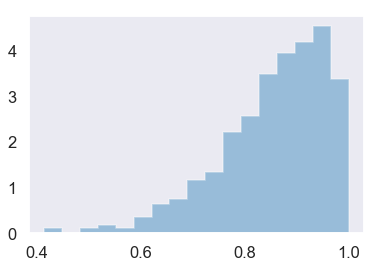

In [100]:
sns.distplot(Y, norm_hist=True, kde=False, hist_kws={'histtype':'stepfilled'});

There is not sufficient statistics?

## Bayesian modelling

In [101]:
# Sampler settings
BURNIN=1000
TUNE=1000
SAMPLES=1000

### Build the model

In [102]:
with pm.Model() as model:
    
    # Prior on 'mu'
    mu = pm.Beta('mu', alpha=1, beta=1)
    
    # Prior on 'phi'
    phi = pm.HalfNormal('phi', sd=25)
    
    # Parametrize in terms of a, b
    alpha = pm.Deterministic('alpha', mu*phi)
    beta = pm.Deterministic('beta', (1-mu)*phi)
    
    #alpha = pm.HalfNormal('alpha', sd=25)
    #beta = pm.HalfNormal('beta', sd=25)    
    
    # Likelihood
    likelihood = pm.Beta('likelihood', alpha=alpha, beta=beta, observed=Y)

In [103]:
model.check_test_point()

mu_logodds__      -1.39
phi_log__         -0.77
likelihood     -3949.81
Name: Log-probability of test_point, dtype: float64

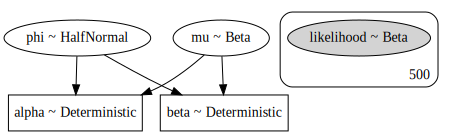

In [104]:
pm.model_to_graphviz(model)

Note: submit issue. Phi and Mu are not display correctly

### Sample from the model

In [105]:
with model:
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=4, random_seed=SEED, nuts_kwargs={'target_accept':0.85})

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, mu]
Sampling 4 chains: 100%|███████████████████████████████████████| 12000/12000 [00:11<00:00, 987.18draws/s]


### Diagnose the sampling

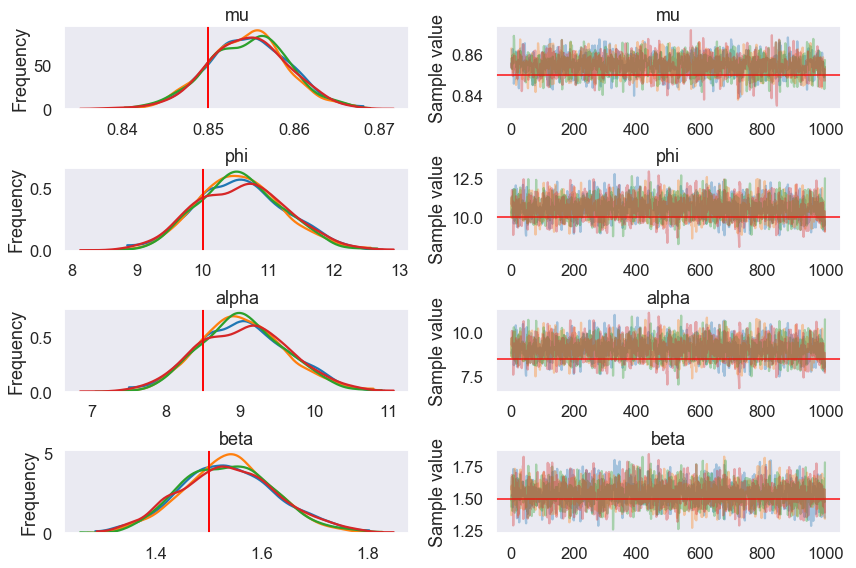

In [106]:
pm.traceplot(trace, lines={'mu':mu_real, 'phi':phi_real, 'alpha':alpha_real, 'beta':beta_real});

### Summarize the posterior density

In [107]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.85,0.00,0.00,0.85,0.86,2512.64,1.0
phi,10.57,0.67,0.01,9.39,11.95,2622.72,1.0
alpha,9.04,0.59,0.01,7.96,10.24,2540.38,1.0
beta,1.54,0.09,0.00,1.36,1.72,3420.09,1.0


### Posterior predictive check

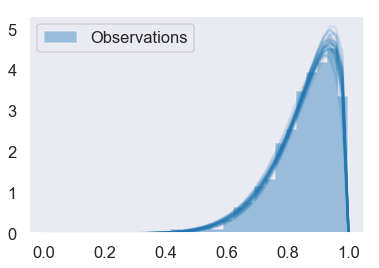

In [108]:
fig, ax = plt.subplots()

THIN = 100
X = np.linspace(0, 1, num=50)

sns.distplot(Y, norm_hist=True, kde=False, label='Observations', hist_kws={'histtype':'stepfilled'})

for a, b in zip(trace['alpha'][::THIN], trace['beta'][::THIN]):
    ax.plot(X, st.beta.pdf(x=X, a=a, b=b), alpha=0.1, color=sns.color_palette()[0])

plt.legend();

## Statistical inference

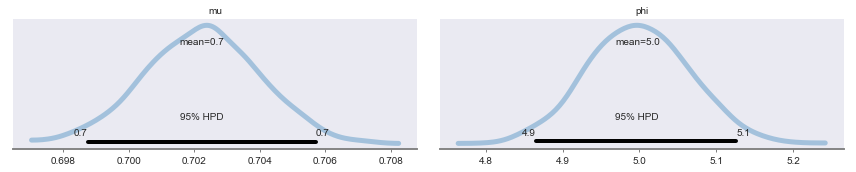

In [29]:
pm.plot_posterior(trace, varnames=['mu', 'phi'], round_to=1, kde_plot=True, lw=5);